In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from hlpr_func import make_cyclic

In [6]:
# ceres insolation and clear-sky fluxes
ceres = make_cyclic(xr.open_mfdataset("CERES-data/CERES_Cru23_ds.nc"))
ceres = ceres[["S"]]

# reanalyses
era = xr.open_dataset("ERA5-CAMS/era5-interpolated.nc")
era = era[["landmask","si10"]]
era = era.rename_vars({"si10":"era_ws"})

merra_ws = xr.open_dataset("MERRA-2/merra2-ws-interpolated.nc")
merra_ws = merra_ws[["SPEED"]].rename_vars({"SPEED":"merra_ws"})

ds = xr.merge([ceres, era, merra_ws])
ceres.close()
era.close()
merra_ws.close()

ds

<xarray.Dataset> Size: 533MB
Dimensions:   (lon: 361, lat: 180, time: 293)
Coordinates:
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 2kB 2000-01-15 2000-02-15 ... 2024-05-15
Data variables:
    S         (time, lat, lon) float32 76MB nan nan nan nan ... nan nan nan nan
    landmask  (time, lat, lon) float64 152MB nan nan nan nan ... nan nan nan nan
    era_ws    (time, lat, lon) float64 152MB nan nan nan nan ... nan nan nan nan
    merra_ws  (time, lat, lon) float64 152MB 5.961 5.968 5.976 ... 6.09 nan
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Revised data Release Date January 2, 2024
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF_L3B004.2

In [7]:
# add extra coord
da = ds.assign_coords({"month_since_start": ("time", np.arange(len(ds.time.values)))})

# select only DJF
djf = da.where(ds.time.dt.month.isin([12,1,2]))

# remove austrailian bush fires (Dec 2019 - Mar 2020)
djf = djf.where(~(djf.time.dt.year.isin(2019) & djf.time.dt.month.isin(12)))
djf = djf.where(~(djf.time.dt.year.isin(2020) & djf.time.dt.month.isin([1,2])))

# add weights
weights = djf.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
djf["days_in_month"] = weights

# calculate climatology and remove seasons
climatology = djf.groupby("time.month").mean("time")
deseasonalized = djf.groupby("time.month") - climatology + climatology.weighted(climatology.days_in_month).mean("month")

# select Southern Ocean
so = deseasonalized.sel(lat=slice(-75,-45)).where(deseasonalized.landmask==0)
so["days_in_month"] = weights


# swap time to monotonic index
da = so.swap_dims({"time":"month_since_start"})

# calculate linear trend
polyfit_result = da.polyfit("month_since_start", 1, skipna=True,  w=da.days_in_month)
trend = polyfit_result.sel(degree=1) * 120 # per decade
for v in trend.keys():
    trend = trend.rename_vars({v:v.split("_polyfit")[0]})

trend

<xarray.Dataset> Size: 348kB
Dimensions:        (lon: 361, lat: 30)
Coordinates:
    degree         int64 8B 1
  * lon            (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5 360.5
  * lat            (lat) float32 120B -74.5 -73.5 -72.5 ... -47.5 -46.5 -45.5
Data variables:
    S              (lat, lon) float64 87kB nan nan nan ... -0.03878 -0.03878 nan
    landmask       (lat, lon) float64 87kB nan nan nan nan ... 0.0 0.0 0.0 nan
    era_ws         (lat, lon) float64 87kB nan nan nan ... 0.01515 0.05289 nan
    merra_ws       (lat, lon) float64 87kB nan nan nan nan ... 0.1386 0.1441 nan
    days_in_month  float64 8B 0.003023

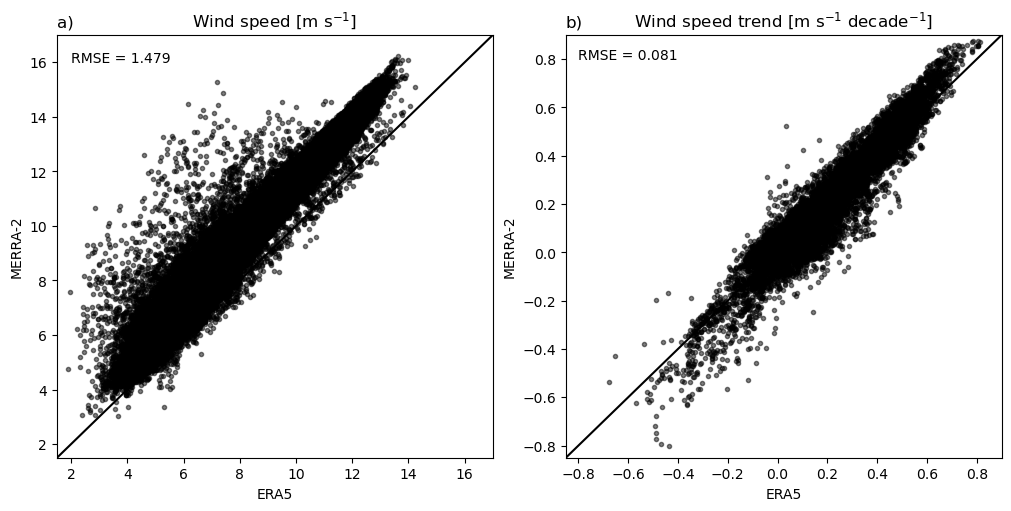

In [8]:
fig,axes = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)

ax = axes[0]
ax.plot(so.era_ws.values.flatten(), so.merra_ws.values.flatten(), "k.", alpha=0.5)
rmse = np.sqrt(np.nanmean((so.merra_ws.values - so.era_ws.values)**2))
ax.text(2, 16, f"RMSE = {rmse:.3f}")
ax.plot([1.5,17],[1.5,17], "k-")
ax.set_xlim([1.5,17])
ax.set_ylim([1.5,17])
ax.set_xlabel("ERA5")
ax.set_ylabel("MERRA-2")
ax.set_title("Wind speed [m s$^{-1}$]")
ax.set_title("a)", loc="left")

ax = axes[1]
ax.plot(trend.era_ws.values.flatten(), trend.merra_ws.values.flatten(), "k.", alpha=0.5)
rmse = np.sqrt(np.nanmean((trend.merra_ws.values - trend.era_ws.values)**2))
ax.text(-0.8, 0.8, f"RMSE = {rmse:.3f}")
ax.plot([-0.85,0.9],[-0.85,0.9], "k-")
ax.set_xlim([-0.85,0.9])
ax.set_ylim([-0.85,0.9])
ax.set_xlabel("ERA5")
ax.set_ylabel("MERRA-2")
ax.set_title("Wind speed trend [m s$^{-1}$ decade$^{-1}$]")
ax.set_title("b)", loc="left")

plt.savefig("paper-figures/era-merra-ws.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()